In [6]:
import csv
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import astropy.units as u
from astropy.modeling.models import Sine1D
from sklearn.linear_model import LinearRegression
import pandas as pd
from astropy.modeling import models, fitting
from lightkurve.correctors import PLDCorrector
import lmfit

In [58]:
palette = sns.color_palette(palette='flare')
palette

[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [8]:
# Define dataframes
df = pd.read_csv('comma_test_query.csv')
all_df = df[['iau_name', 'i', 'porb', 'porbe']]

# Dataframe with orbital period calculations
porb_df = all_df[all_df['porb'] != 0].reset_index()
# Dataframe without orbital period calculations
no_porb_df = all_df[all_df['porb'] == 0].reset_index()

In [100]:
# Define a sine wave function
def sine_wave(x, amplitude, frequency, phase):
    return amplitude * np.sin((2 * np.pi * frequency * x) + phase)

SDSSJ013851.54-001621.6

In [26]:
# Pull lightcurve data for that star
star_info = porb_df.iloc[2]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                            30
iau_name    SDSSJ013851.54-001621.6
i                             15.89
porb                       1.746529
porbe                           0.0
Name: 2, dtype: object 

SearchResult containing 12 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 70 2023              SPOC     120   241444875      0.0
  1 TESS Sector 03 2018         TESS-SPOC    1800   241444875      0.0
  2 TESS Sector 30 2020         TESS-SPOC     600   241444875      0.0
  3 TESS Sector 42 2021         TESS-SPOC     600   241444875      0.0
  4 TESS Sector 43 2021         TESS-SPOC     600   241444875      0.0
  5 TESS Sector 30 2020               QLP     600   241444875      0.0
  6 TESS Sector 42 2021               QLP     600   241444875      0.0
  7 TESS Sector 43 2021               QLP 

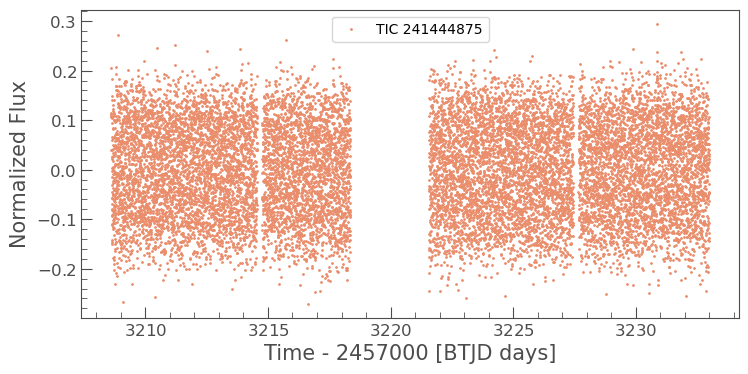

In [86]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[0])
plt.legend()
plt.show()

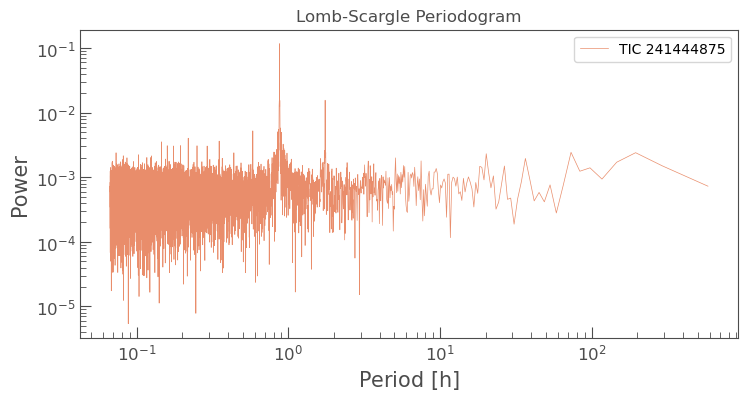

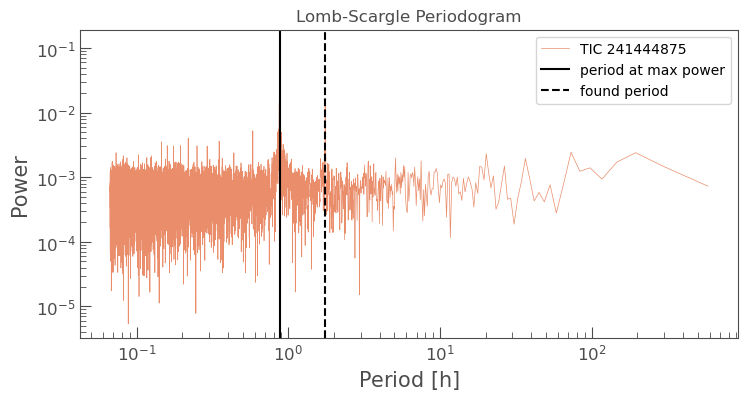

Original calculated period(h): 1.746529 
Period at max power(h): 0.8732017722876133


In [123]:
# Make periodogram
found_period = 1.746529
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.axvline(x = found_period, color= 'black', ls = '--', label = 'found period')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

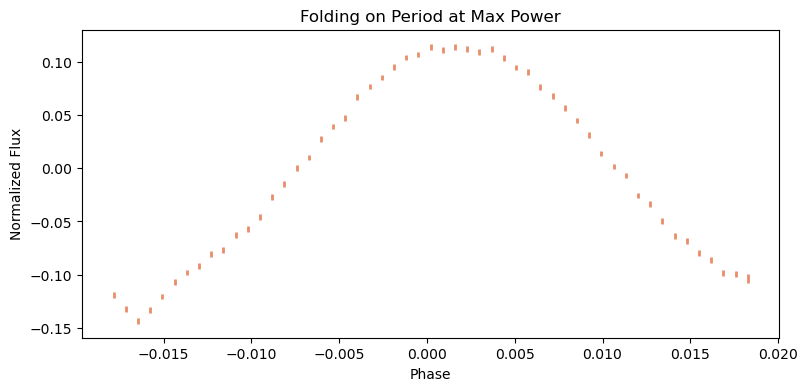

In [114]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(1*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[0], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

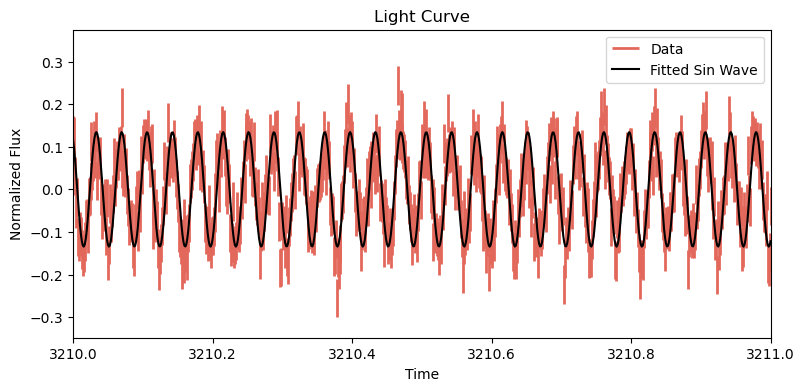

[[Model]]
    Model(sine_wave)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 14937
    # variables        = 3
    chi-square         = 44.2434608
    reduced chi-square = 0.00296260
    Akaike info crit   = -86955.5568
    Bayesian info crit = -86932.7220
    R-squared          = 0.66655897
[[Variables]]
    amplitude: -0.13448848 +/- 0.01203748 (8.95%) (init = 0.1172641)
    frequency:  27.4844076 +/- 9.8693e-05 (0.00%) (init = 27.48506)
    phase:     -0.72908773 +/- 0.23706985 (32.52%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(frequency, phase)     = +0.9998
    C(amplitude, frequency) = -0.9986
    C(amplitude, phase)     = -0.9984


In [126]:
# Lightcurve data
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

# Get the current 'optimal paramteres'
amplitude = max(star_periodogram.power.value)
frequency = 1/star_periodogram.period_at_max_power.value

# Make an lmfit object and fit it
model = lmfit.Model(sine_wave)
params = model.make_params(amplitude=amplitude, frequency=frequency, phase=0.0)
result = model.fit(flux, params, x=time)

# Plot the fitted sin wave
plt.figure(figsize= (9,4))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[1], lw=2, label = 'Data')
plt.plot(time, result.best_fit, color= 'black', label = 'Fitted Sin Wave')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(3210, 3211)
plt.legend()
plt.show()

print(result.fit_report())

In [127]:
# Find period of fitted sin wave
print(24* (1/27.4844076))

0.8732223866451464
